# Import packages

In [1]:
import pandas as pd
import Geohash
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tqdm import tqdm
import random
import pickle

# Import training data

In [2]:
data = pd.read_csv('training.csv')

In [3]:
data.head()

,geohash6,day,timestamp,demand
0,qp03wc,18,20:0,0.020072
1,qp03pn,10,14:30,0.024721
2,qp09sw,9,6:15,0.102821
3,qp0991,32,5:0,0.088755
4,qp090q,15,4:0,0.074468


# Define Data class

In [4]:
class Data:
    def __init__(self, train_data, geohash):
        """
        Initialises the Data object by taking in a dataframe (which serve as the training data) together with its corresponding geohash (which serve as a unique identifier) as input. 
        The function preprocesses the training data and decodes the geohash before storing them as object attributes.
        
        :param data: A dataframe containing the unprocessed training data.
        :type data: dataframe
        
        :param geohash: A six-character unique identifier that encodes the coodinates of particular location.
        :type geohash: string
        """
        self.geohash = geohash
        self.latitude, self.longitude = Geohash.decode(self.geohash)
        temp = self.extract_hour_minute(train_data[['day','timestamp','demand']])
        self.train_data = self.impute_zero_demand(temp)
        self.test_data = None
    
    
    def extract_hour_minute(self, data):
        """
        Extracts the hour and minute information from the timestamp and stores them in separate columns.
        Returns a dataframe (sorted in chronological order) with two additional columns: "hour" and "minute".
        
        : param data: A dataframe containing the unprocessed training/validation/test data.
        : type data: dataframe
        """
        hour, minute = zip(*[timestamp.split(':') for timestamp in data['timestamp']])
        data['hour'] = [int(item) for item in hour]
        data['minute'] = [int(item) for item in minute]
        data.drop(columns=['timestamp'], inplace=True)
        
        return data.sort_values(by=['day','hour','minute']).reset_index(drop=True)
    
    
    def impute_zero_demand(self, data):
        """
        As the unprocessed data is assumed to only store instances where demand is greater than 0, the demand for the other timestamps are imputed (with a zero value) and arranged in chronological order.
        Returns a dataframe containing the demand value for every timestamp in 15 minutes intervals (0, 15, 30, 45).
        
        : param data: A dataframe containing the unprocessed training/validation/test data with the "hour" and "minute" information stored in separate columns.
        : type data: dataframe
        """
        day_list = list(data.groupby('day').groups.keys())
        hour_list = list(range(0, 24, 1))
        minute_list = list(range(0, 60, 15))
        
        time_interval = np.asarray([[day,hour,minute] for day in day_list for hour in hour_list for minute in minute_list], dtype=np.int32)
        new_data = np.hstack((time_interval, np.zeros(shape=(time_interval.shape[0],1))))
        
        for i in range(len(data)):
            index = np.where((new_data[:,0] == data.loc[i,'day']) & (new_data[:,1] == data.loc[i,'hour']) & (new_data[:,2] == data.loc[i,'minute']))
            new_data[index, 3] = data.loc[i,'demand']
            
        return pd.DataFrame(data=new_data, columns=['day','hour','minute','demand'])
    
    
    def plot_demand(self, day):
        """
        Plots the demand of a given day against time in the form of a line plot. 
        In the case where the day of interest cannot be found in the dataset, the demand graph is not plotted.
        
        : param day: An integer value indicating the day of interest.
        : type day: integer
        """
        tick_loc = list(range(0,97,4))
        tick_label = list(range(0,25))
        try:
            grouped_data = self.train_data.groupby('day').get_group(day)
            sns.lineplot(x=list(range(len(grouped_data))), y=grouped_data['demand'])
            plt.xlabel('Time')
            plt.ylabel('Normalised Demand')
            plt.title('Demand VS Time')
            plt.xticks(tick_loc, tick_label)
        except KeyError:
            pass
        
        
    def data_by_time(self, days):
        """
        Extracts the demand information for each day of interest and stores them in a dataframe.
        Returns a dataframe where each row corresponds to the demand for a particular day of interest and each column corresponds to a particular timestamp of the day.
        
        : param days: A list of integer values indicating the days of interest.
        : type days: list
        """
        hour_list = list(range(0, 24, 1))
        minute_list = list(range(0, 60, 15))
        time_interval = [[hour,minute] for hour in hour_list for minute in minute_list]
        
        for day in days:
            try:
                data_array = np.vstack((data_array, self.train_data.groupby('day').get_group(day).values))
            except KeyError:
                pass
            except NameError:
                try:
                    data_array = self.train_data.groupby('day').get_group(day).values
                except KeyError:
                    pass
    
        for hour, minute in time_interval:
            index = np.where((data_array[:,1] == hour) & (data_array[:,2] == minute))
            
            if hour == 0 and minute == 0:
                data_by_time = data_array[index,3].reshape(-1,1)
            else: 
                data_by_time = np.hstack((data_by_time, data_array[index,3].reshape(-1,1)))
        
        return pd.DataFrame(data_by_time, columns=[str(time[0])+':'+str(time[1]) for time in time_interval])
        
        
    def set_test_data(self, test_data):
        """
        Sets the input dataframe as the test data (attribute) of the Data object.
        
        : param test_data: A dataframe containing the validation/test data.
        : type test_data: dataframe
        """
        temp = self.extract_hour_minute(test_data[['day','timestamp','demand']])
        self.test_data = self.impute_zero_demand(temp)
        
        
    def next_batch(self, batch_size, num_time_steps, steps_ahead, training=True):
        """
        Randomly select a few starting points (= batch_size) from the dataset (pre-arranged in chronological order) and store the subsequent data points (= num_time_steps + steps_ahead) ahead in time.
        Returns two 3D arrays where the first 3D array contains the model input and the second 3D array contains the true output for evaluation purposes.
        Shape of both 3D arrays = [batch_size, num_time_steps, 1].
        
        : param batch_size: Indicates the batch size of output.
        : type batch_size: integer
        
        : param num_time_steps: Indicates the number of time steps 
        : type num_time_steps: integer
        
        : param steps_ahead: Indicates the number of time steps the model should predict ahead in time.
        : type steps_ahead: integer
        
        : param training: Indicates whether the data will be used for training or validation/testing purposes. If True, the data will be sampled from the training data. Else, the data will be sampled from the validation/test data.
        : type training: bool
        """
        if training:
            data = self.train_data
        else:
            data = self.test_data
            
        input_columns = ['demand']
        input_dim = len(input_columns)
        rand_start = random.choices(population=range(len(data)-num_time_steps-steps_ahead), k=batch_size) ## randomly initialise the starting point between the first index to the (last index - num_time_steps - steps_ahead)
        y_batch = data[input_columns].values.transpose()
        y_batch = np.asarray([y_batch[:,i:i+num_time_steps+steps_ahead].reshape(num_time_steps+steps_ahead,input_dim) for i in rand_start])

        return y_batch[:,:-steps_ahead,:], y_batch[:,steps_ahead:,:]
        
        
    def test_batch(self, num_time_steps, steps_ahead):
        """
        Splits the entire validation/test dataset (pre-arranged in chronological order) into equal parts of length = (num_time_steps + steps_ahead).
        Returns two 3D arrays where the first 3D array contains the model input and the second 3D array contains the true output for evaluation purposes.
        Shape of both 3D arrays = [?, num_time_steps, 1].
        
        : param num_time_steps: Indicates the number of time steps 
        : type num_time_steps: integer
        
        : param steps_ahead: Indicates the number of time steps the model should predict ahead in time.
        : type steps_ahead: integer
        """
        if self.test_data is None:
            raise ValueError('Test data is not initialised.')
           
        input_columns = ['demand']
        input_dim = len(input_columns)
        start_index = list(range(0, len(self.test_data)-num_time_steps-steps_ahead, num_time_steps+steps_ahead))
        start_index.append(len(self.test_data)-num_time_steps-steps_ahead)  # this ensures that the last few data points are predicted as well
        test_batch = self.test_data[input_columns].values.transpose()
        test_batch = np.asarray([test_batch[:,i:i+num_time_steps+steps_ahead].reshape(num_time_steps+steps_ahead,input_dim) for i in start_index])
        
        return test_batch[:,:-steps_ahead,:], test_batch[:,steps_ahead:,:] 

# Segment the data based on geolocation and perform train validation split

In [5]:
geohash_list = list(data.groupby('geohash6').groups.keys())
data_list = []
gb = data.groupby('geohash6')
train_fraction = 1 - ((len(set(data['day']))/8.0) / len(set(data['day'])))

for i in tqdm(range(len(geohash_list))):
    # Segment the data based on geolocation (using geohash information)
    data_segment = gb.get_group(geohash_list[i])
    
    # Split the data segment into a training set (first 6-7 weeks) and validation set (last 2 weeks)
    day_list = list(data_segment.groupby('day').groups.keys())
    train_size = int(len(day_list) * train_fraction)

    if train_size == 0:
        train_day = day_list
        validation_day = day_list
    else:
        train_day = day_list[:train_size]
        validation_day = day_list[train_size:]

    train_data_segment = data_segment.loc[data_segment['day'].isin(train_day)].reset_index(drop=True)
    validation_data_segment = data_segment.loc[data_segment['day'].isin(validation_day)].reset_index(drop=True)
    
    # Store the training set and validation set into a Data object as attributes
    data_object = Data(train_data_segment, geohash_list[i])
    data_object.set_test_data(validation_data_segment)
    data_list.append(data_object)
    
    if i == 0:
        validation_data = validation_data_segment
    else:
        validation_data = pd.concat([validation_data, validation_data_segment], ignore_index=True)
    
# Combine all of the validation sets into a single CSV file and save it locally for future testing
validation_data.to_csv('validation.csv', index=False)

100%|██████████| 1329/1329 [09:41<00:00,  3.32it/s]


# Define Model class

In [6]:
class Model:
    def __init__(self, data, geohash):
        """
        Initalises the Model object by taking in a Data object together with its corresponding geohash (which serve as a unique identifier) as input. 
        At the same time, the function initialises the hyperparameters of the neural network.
        
        :param data: A Data object containing both the training data and validation/test data sets as attributes.
        :type data: Data object
        
        :param geohash: A six-character unique identifier that encodes the coodinates of particular location.
        :type geohash: string
        """
        self.geohash = geohash
        self.data = data
        self.batch_size = 100
        self.num_time_steps = 20
        self.steps_ahead = 5  # the model predicts up to 5 time steps forward in time
        self.num_neurons = self.num_time_steps
        self.input_dim = 1
        self.output_dim = 1
        self.learning_rate = 0.001
        self.epoch = 10000
        self.num_layers = 3
        
    
    def train_model(self):
        """
        Sets up the architecture of the neural network and begin training the neural network based on the training set in the Data object.
        """
        tf.reset_default_graph()
        
        # Define the variables of the neural network
        X = tf.placeholder(tf.float32, [None, self.num_time_steps, self.input_dim])
        y = tf.placeholder(tf.float32, [None, self.num_time_steps, self.output_dim])
        
        # Define the operations of the neural network
        cell = tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.LSTMCell(num_units=self.num_neurons) for layer in range(self.num_layers)])
        outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
        final_outputs = tf.nn.relu(tf.reshape(outputs[:,-1,:], [self.batch_size,self.num_time_steps,self.output_dim]))
        
        # Define loss function (based on MSE)
        loss = tf.reduce_mean(tf.square(final_outputs-y))
        
        # Initialise the optimiser
        optimiser = tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(loss)
        
        # Initialise the global variables and begin training
        sess = tf.InteractiveSession()
        sess.run(tf.global_variables_initializer())
        saver = tf.train.Saver()
        train_mse_list = []
        test_mse_list = []

        for iteration in tqdm(range(self.epoch)):
            X_train_batch, y_train_batch = self.data.next_batch(batch_size=self.batch_size, num_time_steps=self.num_time_steps, steps_ahead=self.steps_ahead)
            sess.run(optimiser, feed_dict={X:X_train_batch, y:y_train_batch})
                
            # Track the training progress
            if iteration % 100 == 0:
                train_mse = loss.eval(feed_dict={X:X_train_batch, y:y_train_batch})
                train_mse_list.append(train_mse)
                
                X_test_batch, y_test_batch = self.data.next_batch(batch_size=self.batch_size, num_time_steps=self.num_time_steps, steps_ahead=self.steps_ahead, training=False)
                test_prediction, test_mse = sess.run([final_outputs,loss],feed_dict={X:X_test_batch, y:y_test_batch})
                test_mse_list.append(test_mse)
            
        # Save the pre-train model for future testing
        saver.save(sess, './models/' + self.geohash)
        sess.close()
        
        # Plot the training progress based on MSE
        sns.lineplot(x=list(range(len(train_mse_list))), y=train_mse_list, label='Training')
        sns.lineplot(x=list(range(len(test_mse_list))), y=test_mse_list, label='Test')
        plt.show()
        
        
    def test_model(self):
        """
        Sets up the architecture of the neural network and loads the pre-trained model for testing based on the validation/test set in the Data object. 
        Returns a float value containing the test results (MSE score).
        """
        tf.reset_default_graph()
        
        # Define the variables of the neural network
        X = tf.placeholder(tf.float32, [None, self.num_time_steps, self.input_dim])
        y = tf.placeholder(tf.float32, [None, self.num_time_steps, self.output_dim])
        
        # Define the operations of the neural network
        cell = tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.LSTMCell(num_units=self.num_neurons) for layer in range(self.num_layers)])
        outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
        final_outputs = tf.nn.relu(tf.reshape(outputs[:,-1,:], [-1,self.num_time_steps,self.output_dim]))
        
        # Define loss function (based on MSE)
        loss = tf.reduce_mean(tf.square(final_outputs-y))
        
        # Initialise the optimiser
        optimiser = tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(loss)
        
        # Initialise the global variables and reload the pre-train model
        sess = tf.InteractiveSession()
        saver = tf.train.Saver()
        saver.restore(sess, './models/' + self.geohash)
        sess.run(tf.global_variables_initializer())
        
        # Begin testing
        X_test_batch, y_test_batch = self.data.test_batch(num_time_steps=self.num_time_steps, steps_ahead=self.steps_ahead)
        test_mse = loss.eval(feed_dict={X:X_test_batch, y:y_test_batch})

        sess.close()
        
        return test_mse

# Train models according to geolocation

In [7]:
model_list = []

for i in range(len(data_list)):
    # Create a Model object which accesses its corresponding Data object to perform training and validation
    print('Training {} out of {}'.format(i+1, len(data_list)))
    model = Model(data_list[i], data_list[i].geohash)
    # The line of code below instructs the Model object to begin the training process.
    model.train_model()
    model_list.append(model)

Training 1 out of 1329
Training 2 out of 1329
Training 3 out of 1329
Training 4 out of 1329
Training 5 out of 1329
Training 6 out of 1329
Training 7 out of 1329
Training 8 out of 1329
Training 9 out of 1329
Training 10 out of 1329
Training 11 out of 1329
Training 12 out of 1329
Training 13 out of 1329
Training 14 out of 1329
Training 15 out of 1329
Training 16 out of 1329
Training 17 out of 1329
Training 18 out of 1329
Training 19 out of 1329
Training 20 out of 1329
Training 21 out of 1329
Training 22 out of 1329
Training 23 out of 1329
Training 24 out of 1329
Training 25 out of 1329
Training 26 out of 1329
Training 27 out of 1329
Training 28 out of 1329
Training 29 out of 1329
Training 30 out of 1329
Training 31 out of 1329
Training 32 out of 1329
Training 33 out of 1329
Training 34 out of 1329
Training 35 out of 1329
Training 36 out of 1329
Training 37 out of 1329
Training 38 out of 1329
Training 39 out of 1329
Training 40 out of 1329
Training 41 out of 1329
Training 42 out of 1329
T

# Save Data and Model objects on a local directory for data persistance

In [8]:
with open('geohash_list.pkl', 'wb') as output_file:
    pickle.dump(geohash_list, output_file, pickle.HIGHEST_PROTOCOL)

In [9]:
with open('data_objects.pkl', 'wb') as output_file:
    pickle.dump(data_list, output_file, pickle.HIGHEST_PROTOCOL)

In [10]:
with open('model_objects.pkl', 'wb') as output_file:
    pickle.dump(model_list, output_file, pickle.HIGHEST_PROTOCOL)

# Other potential input features that could be included in the model

### Day of Week

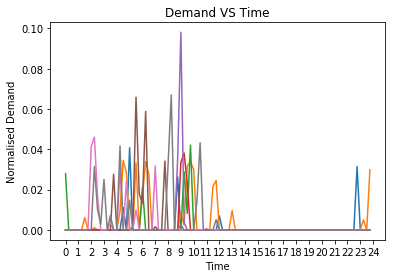

In [11]:
# Visualising demand based on Day of Week

index = 0  # index should range between 0 to 1328 (integer value)
dayofweek = 2  # dayofweek should range between 1 to 7 (integer value) to represent one of the weekdays.
dayofweek_list = list(range(dayofweek,62,7))

for day in dayofweek_list:
    data_list[index].plot_demand(day)

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
        35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
        52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
        69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
        86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96]),
 <a list of 96 Text xticklabel objects>)

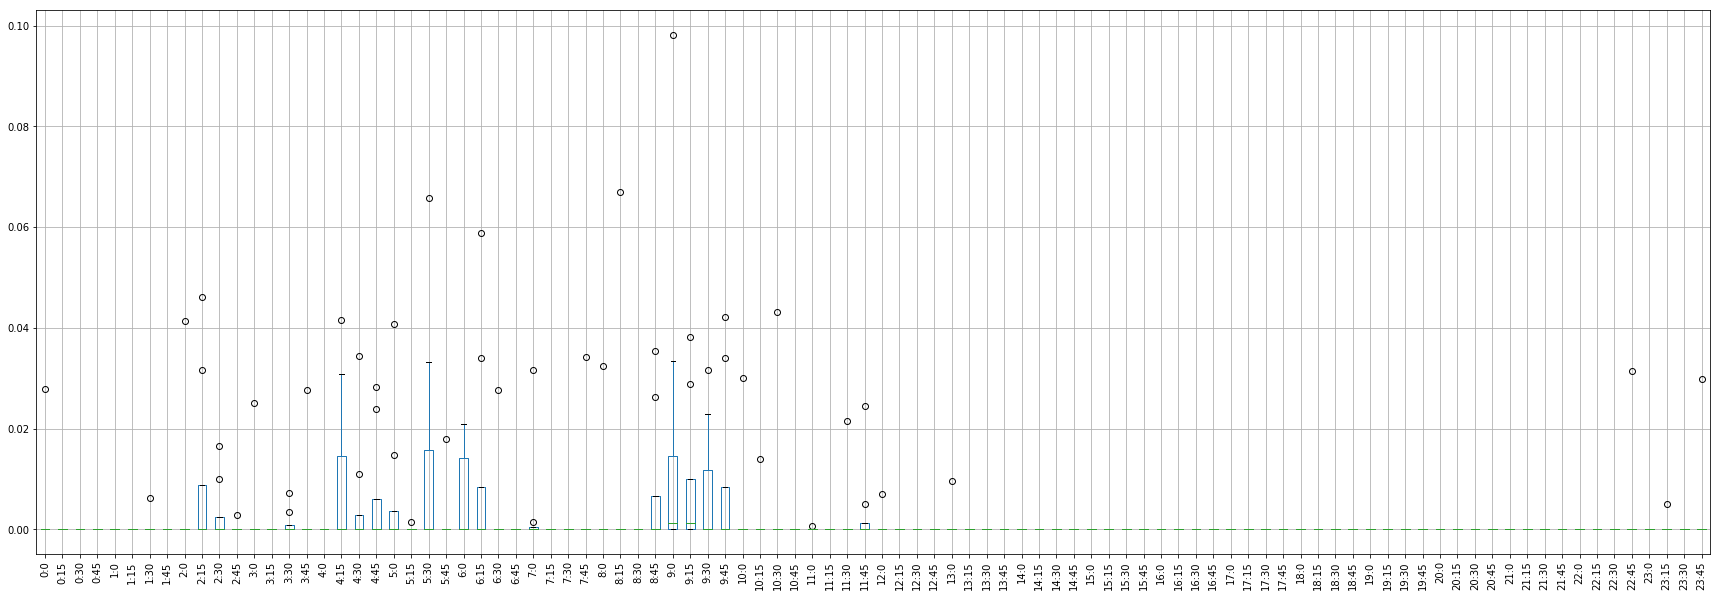

In [12]:
# Calculating descriptive statistics of demand based on Day of Week

index = 0  # index should range between 0 to 1328 (integer value)
dayofweek = 2  # dayofweek should range between 1 to 7 (integer value) to represent one of the weekdays.
dayofweek_list = list(range(dayofweek,62,7))

day_by_time = data_list[index].data_by_time(dayofweek_list)
plt.figure(figsize=(30,10))
day_by_time.boxplot(column=list(day_by_time.columns))
plt.xticks(rotation=90)

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
        35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
        52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
        69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
        86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96]),
 <a list of 96 Text xticklabel objects>)

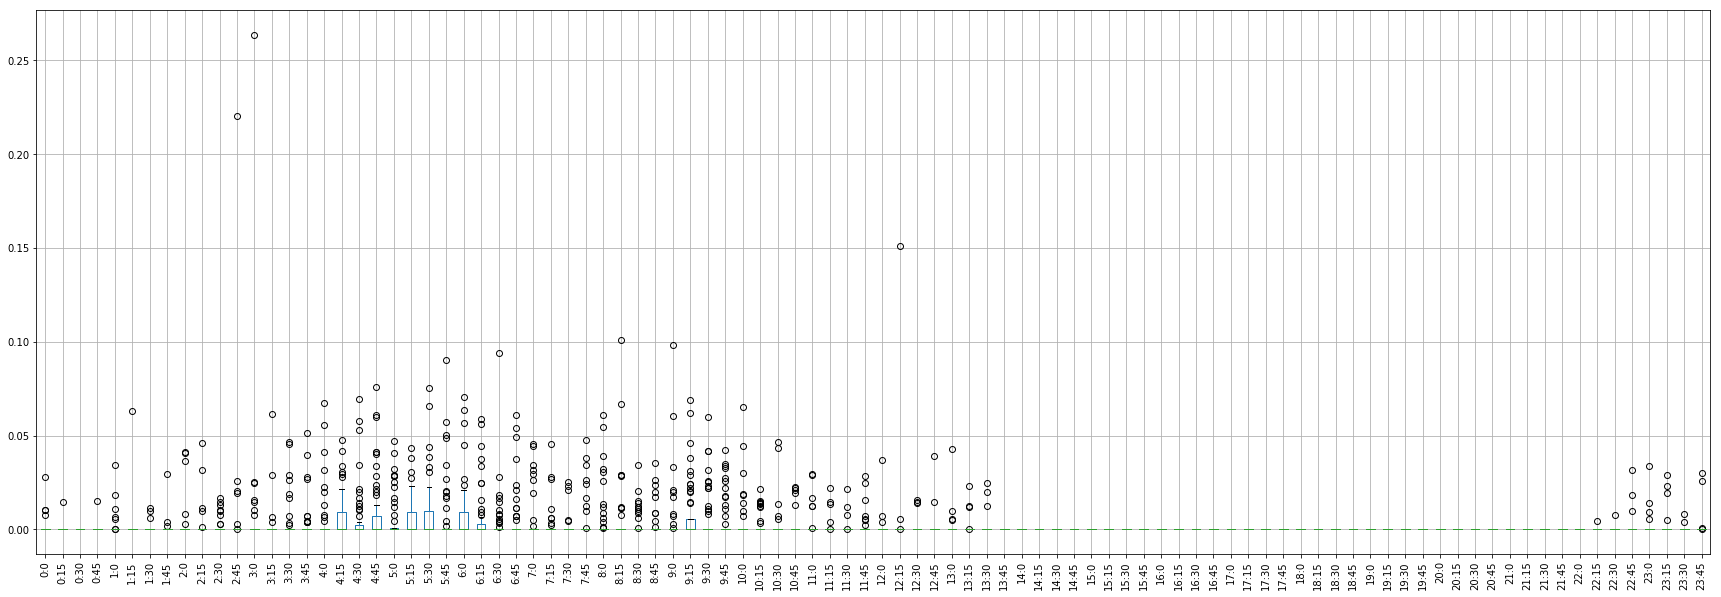

In [13]:
# Calculating descriptive statistics of demand for all days

index = 0  # index should range between 0 to 1328 (integer value)
dayofweek = 1
dayofweek_list = list(range(dayofweek,62,1))

day_by_time = data_list[index].data_by_time(dayofweek_list)
plt.figure(figsize=(30,10))
day_by_time.boxplot(column=list(day_by_time.columns))
plt.xticks(rotation=90)

Based on the above visualisation of demand filtered according to the Day of Week information (Monday, Tuesday, etc), it is very likely that the inclusion of Day of Week information would be a useful input feature when predicting the demand at a particular geolocation. For instance, the demand at a shopping mall differs greatly between a weekday and a weekend. The same argument applies for residential locations when we are comparing the demand between a working day and a non-working day. Based on the Day of Week information, we can even extract other useful features such as the mean and variance of demand at every timestamp.

Currently, the Day of Week information can be deduced from the "day" column in the data file (i.e. 1, 8, 15, etc). However, given that it is unclear whether the test data will continue from the last day of the training data (Day 62) or start from Day 1, a decision was made to not include this input feature in the model as a wrong assumption will introduce noise into the final model, and negatively impact the test performance.

### Point of interest (POI) information

Another possible input feature that could be included in the model is the different point of interest information that comes with the geographic location. For instance, in locations that contain a high concentration of retail establishments such as shopping malls and pubs, you can expect the demand for ride sharing services to increase as we approach the closing hours of those establishments.

However, given that the geohashes are anonymised, this particular input feature could not be included in the model.